Code from [scale embedding-decoder](https://git.scc.kit.edu/scale/research/embedding-decoder) with slight changes

In [11]:
import tensorflow as tf
import random
import networkx as nx
import math
import numpy as np

from util.map import Map

In [53]:
args = Map(
    batch_size = 64,
    epochs = 7,
    random_seed = None,
    graph_size = 1000,
    graph_average_degree = 10,
    layers = 3,
    layer_size = 16
)

Nodes: 1000
Edges: 4790
Average Degree: 9.58


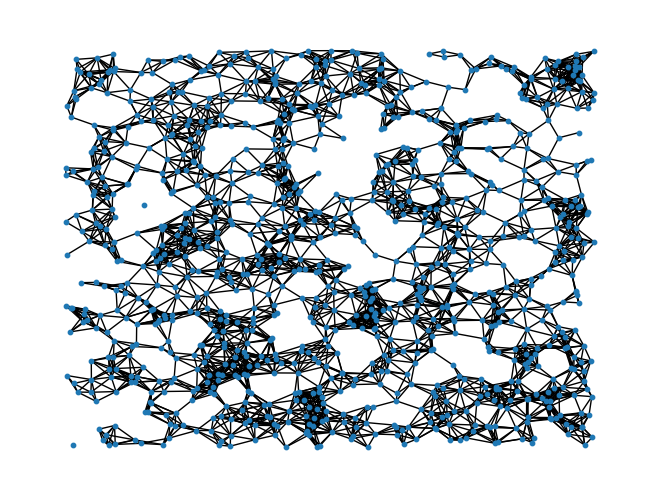

In [55]:
rg_radius = math.sqrt(args.graph_average_degree / (args.graph_size * math.pi))

pos = {i: (random.uniform(0, 1), random.uniform(0, 1)) for i in range(args.graph_size)}
nx_graph = nx.random_geometric_graph(args.graph_size, rg_radius, pos=pos)  # not based on rng seed yet!
largest_component = max(nx.connected_components(nx_graph), key=len)

print(f'Nodes: {nx_graph.number_of_nodes()}')
print(f'Edges: {nx_graph.number_of_edges()}')
print(f'Average Degree: {2.0 * nx_graph.number_of_edges() / nx_graph.number_of_nodes()}')
nx.draw(nx_graph, pos, node_size=10)

In [16]:
# tensorflow

# generate dataset from graph. checks and remembers for all pairs of nodes if they were connected by an edge or not.
ds_matracies = []
ds_labels = []
adj = nx.adjacency_matrix(nx_graph)
nodes = nx.nodes(nx_graph)

for x in range(nx_graph.number_of_nodes()):
    for y in range(nx_graph.number_of_nodes()):
        ds_matracies.append(np.append((nodes[x]['pos']), (nodes[y]['pos'])))
                              #append (shape(4)) or vstack (shape(2,2))? probably no difference for an AI
        ds_labels.append(1 if nx_graph.has_edge(x, y) else 0)

full_dataset = tf.data.Dataset.from_tensor_slices((ds_matracies, ds_labels)).batch(args.batch_size)

#print(f'Dataset size: {full_dataset.__len__}')
#print(full_dataset)

# note: here is no split into train/validation/test
# since the idea was for the AI to learn one graph and not for it to generalize,
# we thought it more appropriate to overtrain the Network.
# This has so far not been compared to networks trained on split sets.


#build model(s)
model_array = [
    tf.keras.layers.InputLayer(input_shape=(4))] #possible TODO get inputshape dynamically

for i in range(args.layers):
    model_array.append(tf.keras.layers.Dense(args.layer_size, activation='relu')) #make size depending of graph dimensionality? Or would that against the idea?

model_array.append(tf.keras.layers.Flatten())
model_array.append(tf.keras.layers.Dense(1, activation='sigmoid'))

dense_model = tf.keras.Sequential(model_array)

dense_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

# train
train_history = dense_model.fit(full_dataset, epochs=args.epochs)

# evaluate
test_loss, test_acc = dense_model.evaluate(full_dataset, verbose=0)
#print('\nTest accuracy:', test_acc)
#print('\nTrain history:', train_history.history)
dense_model.summary()

probability_model = tf.keras.Sequential([dense_model, tf.keras.layers.Softmax()])

C:\Users\Paul\AppData\Local\Temp\ipykernel_19388\134340058.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(nx_graph)


Epoch 1/7
157/157 [==============================] - 1s 1ms/step - loss: 0.3360 - accuracy: 0.9228
Epoch 2/7
157/157 [==============================] - 0s 886us/step - loss: 0.2744 - accuracy: 0.9228
Epoch 3/7
157/157 [==============================] - 0s 872us/step - loss: 0.2543 - accuracy: 0.9228
Epoch 4/7
157/157 [==============================] - 0s 891us/step - loss: 0.2134 - accuracy: 0.9228
Epoch 5/7
157/157 [==============================] - 0s 949us/step - loss: 0.1667 - accuracy: 0.9228
Epoch 6/7
157/157 [==============================] - 0s 991us/step - loss: 0.1288 - accuracy: 0.9256
Epoch 7/7
157/157 [==============================] - 0s 994us/step - loss: 0.1041 - accuracy: 0.9467
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 16)                80        
                                                                 
 dense_9 